In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import collections
import seaborn as sns
from datetime import datetime

In [2]:
df = pd.read_csv("dataset/complaint_data.csv")

# Removing outliers
df = df[~(df['CMPLNT_TO_DT'] >= '2017-01-01')]
df = df[~(df['ZIPCODE'] == 83)]

# Data cleansing - removing null columns and data points
# Redundant columns
dropcols = ["Lat_Lon","X_COORD_CD","Y_COORD_CD","CMPLNT_NUM","CMPLNT_TO_DT","RPT_DT","CMPLNT_TO_TM"] 
for i in df.columns:
    if float(df[i].isnull().sum())/len(df)*100 > 20: # if more than 10% data is empty, clip the column
        dropcols.append(i)
df = df.drop(dropcols, axis=1)
df = df[~df.isnull().any(axis=1)]

df["CMPLNT_FR_DT"] = df["CMPLNT_FR_DT"].apply(lambda x: datetime.strptime(x, '%m/%d/%y')
                                              .strftime('%Y-%m-%d')).astype('datetime64[ns]')
df["CMPLNT_FR_DT"] = pd.to_datetime(df["CMPLNT_FR_DT"])

# Converting time of crimes into Timezones and Dates into only the month in which they occur
df['month'] = df['CMPLNT_FR_DT'].map(lambda x: x.month)
df = df.reset_index(drop=True)
df["timezone"] = df["CMPLNT_FR_TM"].apply(lambda x: int(x.strip().split(':')[0])//6)

In [3]:
# Compiling list of Offenses, their categories and key codes

offense_code = {}
offlist = df["OFNS_DESC"].unique()
for each in offlist:
    key = df[df["OFNS_DESC"]==each]["KY_CD"].unique()[0]
    offense_code[key] = each

print "Offense Codes and Description " + str(len(offense_code))
print ""
offense_code = collections.OrderedDict(sorted(offense_code.items()))
for k,v in offense_code.items():
    print k,v
    
# Repeating the same for Police Codes and Descriptions

pd_code = {}
pdlist = df["PD_DESC"].unique()
for each in pdlist:
    key = df[df["PD_DESC"]==each]["PD_CD"].unique()[0]
    pd_code[key] = each

print ""
print "Police Department Codes and Descriptions " + str(len(pd_code))
pd_code = collections.OrderedDict(sorted(pd_code.items()))
for k,v in pd_code.items():
    print k,v

# INFERENCES
# Using only KY_CD for analysis as KY_CD and PD_CD cover similar ground of information and thus redundant to use both.

Offense Codes and Description 54

102 HOMICIDE-NEGLIGENT-VEHICLE
103 HOMICIDE-NEGLIGENT,UNCLASSIFIE
105 ROBBERY
106 FELONY ASSAULT
107 BURGLARY
109 GRAND LARCENY
110 GRAND LARCENY OF MOTOR VEHICLE
112 THEFT-FRAUD
113 FORGERY
114 ARSON
116 SEX CRIMES
117 DANGEROUS DRUGS
118 DANGEROUS WEAPONS
119 INTOXICATED/IMPAIRED DRIVING
120 ENDAN WELFARE INCOMP
124 KIDNAPPING
125 NYS LAWS-UNCLASSIFIED FELONY
126 MISCELLANEOUS PENAL LAW
230 JOSTLING
231 BURGLAR'S TOOLS
232 POSSESSION OF STOLEN PROPERTY
237 ESCAPE 3
238 FRAUDULENT ACCOSTING
340 FRAUDS
341 PETIT LARCENY
342 PETIT LARCENY OF MOTOR VEHICLE
343 THEFT OF SERVICES
344 ASSAULT 3 & RELATED OFFENSES
345 OFFENSES RELATED TO CHILDREN
346 ALCOHOLIC BEVERAGE CONTROL LAW
347 INTOXICATED & IMPAIRED DRIVING
348 VEHICLE AND TRAFFIC LAWS
349 DISRUPTION OF A RELIGIOUS SERV
350 GAMBLING
351 CRIMINAL MISCHIEF & RELATED OF
352 CRIMINAL TRESPASS
353 UNAUTHORIZED USE OF A VEHICLE
354 ANTICIPATORY OFFENSES
355 OFFENSES AGAINST THE PERSON
356 PROSTITUTION & RE

In [4]:
# Collecting list of Precincts and the list of Zipcodes from the dataset

zipcodes = list(df['ZIPCODE'].unique())
zipcodes.sort()
#zipcodes = zipcodes[1:]
zipcodes = map(int,zipcodes)

precincts = list(df['ADDR_PCT_CD'].unique())
precincts.sort()

In [5]:
# Part A: Feature Engineering to extract crime statistics across Zipcodes

columns = ["Zipcode", "Borough", "Avg_timezone0","Avg_timezone1","Avg_timezone2","Avg_timezone3",
           "Avg_month","Monthly_trend","Avg_felony","Felony_trend","Avg_misdem","Misdem_trend",
           "Avg_vio","Vio_trend","Threat_to_PB"]

zip_df = pd.DataFrame(index=np.arange(len(zipcodes)),columns=columns)
zip_df["Zipcode"] = zipcodes

boroughs = []
timezone0 = []
timezone1 = []
timezone2 = []
timezone3 = []
month = []
felony = []
misdem = []
vio = []

# 1. Average number of crimes across each timezone, monthly averages, law category average for every Zipcode
for i in range(len(zip_df)):
    z = zip_df.iloc[i]["Zipcode"]
    boroughs.append(df[df["ZIPCODE"]==z]["BORO_NM"].unique()[0].title())
    
    timezone0.append(len(df[(df["ZIPCODE"]==z) & (df["timezone"]==0)]))
    timezone1.append(len(df[(df["ZIPCODE"]==z) & (df["timezone"]==1)]))
    timezone2.append(len(df[(df["ZIPCODE"]==z) & (df["timezone"]==2)]))
    timezone3.append(len(df[(df["ZIPCODE"]==z) & (df["timezone"]==3)]))
    month.append(float(len(df[df["ZIPCODE"]==z]))/12)
    
    felony.append(float(len(df[(df["ZIPCODE"]==z) & (df["LAW_CAT_CD"]=="FELONY")]))/12)
    misdem.append(float(len(df[(df["ZIPCODE"]==z) & (df["LAW_CAT_CD"]=="MISDEMEANOR")]))/12)
    vio.append(float(len(df[(df["ZIPCODE"]==z) & (df["LAW_CAT_CD"]=="VIOLATION")]))/12)
    
zip_df["Borough"] = boroughs
zip_df["Avg_timezone0"] = timezone0
zip_df["Avg_timezone1"] = timezone1
zip_df["Avg_timezone2"] = timezone2
zip_df["Avg_timezone3"] = timezone3
zip_df["Avg_month"] = month
zip_df["Avg_felony"] = felony
zip_df["Avg_misdem"] = misdem
zip_df["Avg_vio"] = vio

# Combining Population of each Zipcode with the current data

df_census = pd.read_csv("dataset/censusbyzip.csv", index_col=None)
df_census.columns = ["Zipcode","Population"]
zip_df = pd.merge(zip_df, df_census, on=['Zipcode'])

In [6]:
# 2. Using Correlation to find linear trends in the crime statistics

mon_trend = []
fel_trend = []
mis_trend = []
vio_trend = []

for i in range(len(zip_df)):
    z = zip_df.iloc[i]["Zipcode"]
    mon = np.zeros((12,))
    fel = np.zeros((12,))
    mis = np.zeros((12,))
    viol = np.zeros((12,))
    
    for j in range(12):
        mon[j] = len(df[(df["ZIPCODE"]==z) & (df["month"]==j)])
        fel[j] = len(df[(df["ZIPCODE"]==z) & (df["LAW_CAT_CD"]=="FELONY") & (df["month"]==j)])
        mis[j] = len(df[(df["ZIPCODE"]==z) & (df["LAW_CAT_CD"]=="MISDEMEANOR") & (df["month"]==j)])
        viol[j] = len(df[(df["ZIPCODE"]==z) & (df["LAW_CAT_CD"]=="VIOLATION") & (df["month"]==j)])
    
    # Find correlation in them
    mon_trend.append(np.corrcoef(np.arange(12),mon)[0,1])
    fel_trend.append(np.corrcoef(np.arange(12),fel)[0,1])
    mis_trend.append(np.corrcoef(np.arange(12),mis)[0,1])
    vio_trend.append(np.corrcoef(np.arange(12),viol)[0,1])

zip_df["Monthly_trend"] = mon_trend
zip_df["Felony_trend"] = fel_trend
zip_df["Misdem_trend"] = mis_trend
zip_df["Vio_trend"] = vio_trend

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [7]:
# 3. Calculate threat to either Person or Belonging based on key codes and offense descriptions - Threat_to_PB

rel_persons = set(["ASSUALT","HOMICIDE","FELONY","ARSON","SEX","INTOXICATED","DANGEROUS","DRUGS","WEAPONS",
               "KIDNAPPING","CRIMINAL","PENAL"])
rel_things = set(["ROBBERY","BURGLARY","LARCENY","THEFT","FRAUD","FORGERY","STOLEN","FRAUDULENT"])

harms_people = [102,103]
harms_things = [112]
for k,v in offense_code.items():
    temp = v.strip().split()
    for i in temp:
        if i in rel_persons:
            harms_people.append(k)
            break
        elif i in rel_things:
            harms_things.append(k)
            break

ratio = []
for i in range(len(zip_df)):
    z = zip_df.iloc[i]["Zipcode"]
    val_p = 0
    val_t = 0
    for j in harms_people:
        val_p += len(df[(df["ZIPCODE"]==z) & (df["KY_CD"]==j)])
    for j in harms_things:
        val_t += len(df[(df["ZIPCODE"]==z) & (df["KY_CD"]==j)])
    if val_t==0:
        val_t = 1
    ratio.append(float(val_p)/val_t)
zip_df["Threat_to_PB"] = ratio

In [8]:
# Now that the Datasetis ready, lets run a basic KMeans Clustering algorithm to see 3 categories 
# - Safe, Neutral, Unsafe. Hence k = 3 clusters
# All features at this point are plain numeric in nature, nothing is categorical except Zipcode and Borough

In [9]:
# KMeans Algorithm

zip_df = zip_df[~zip_df.isnull().any(axis=1)]
from sklearn.cluster import KMeans
def clustering(train, n):
    kmeans = KMeans(n_clusters=n, random_state=0,).fit(train)
    return kmeans.cluster_centers_, kmeans.labels_

usecols = ["Avg_timezone0","Avg_timezone1","Avg_timezone2","Avg_timezone3","Avg_month","Monthly_trend",
        "Avg_felony","Felony_trend","Avg_misdem","Misdem_trend","Avg_vio","Vio_trend","Threat_to_PB"]

num_clusters = 3
centers, labels = clustering(zip_df[usecols],num_clusters) 

zip_df['labels'] = labels
print zip_df['labels'].value_counts()

2    85
0    64
1    35
Name: labels, dtype: int64


In [10]:
# Results per Zipcode

cluster0 = zip_df[zip_df['labels']==0]
cluster1 = zip_df[zip_df['labels']==1]
cluster2 = zip_df[zip_df['labels']==2]
print cluster0["Borough"].value_counts()
print cluster1["Borough"].value_counts()
print cluster2["Borough"].value_counts()

Brooklyn         19
Manhattan        18
Queens           16
Bronx             6
Staten Island     5
Name: Borough, dtype: int64
Bronx        15
Brooklyn     11
Manhattan     8
Queens        1
Name: Borough, dtype: int64
Queens           48
Manhattan        19
Staten Island     7
Brooklyn          7
Bronx             4
Name: Borough, dtype: int64


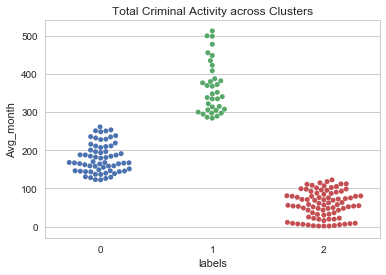

In [26]:
# Tests to see if the clusters had segregated well enough and to identify which cluster marks High criminal activity

# 1. Average monthly crime stats
sns.set(style="whitegrid", color_codes=True)
sns.swarmplot(x="labels", y="Avg_month", data=zip_df)
plt.title("Total Criminal Activity across Clusters")
plt.show()

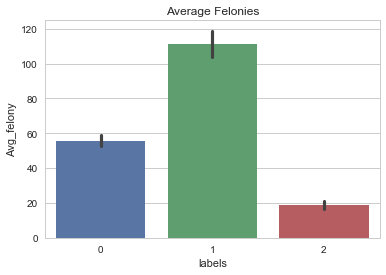

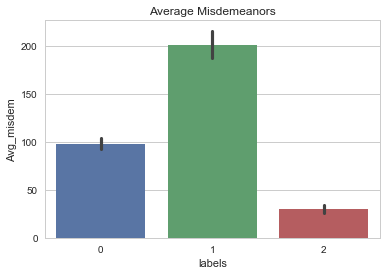

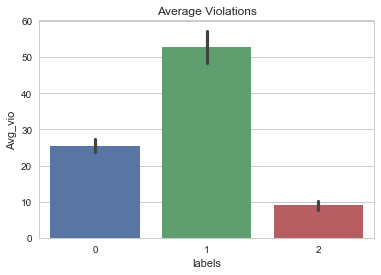

In [25]:
# 2. Comparing Crime stats for every category of crime - Felony, Misdemeanor, Violation
sns.barplot(x="labels", y="Avg_felony", data=zip_df)
plt.title("Average Felonies")
plt.show()

sns.barplot(x="labels", y="Avg_misdem", data=zip_df)
plt.title("Average Misdemeanors")
plt.show()

sns.barplot(x="labels", y="Avg_vio", data=zip_df)
plt.title("Average Violations")
plt.show()

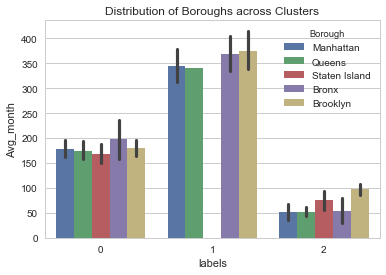

In [33]:
# 3. Distribution of Boroughs across Clusters
sns.barplot(x="labels", y="Avg_month", hue="Borough",data=zip_df)
plt.title("Distribution of Boroughs across Clusters")
plt.show()

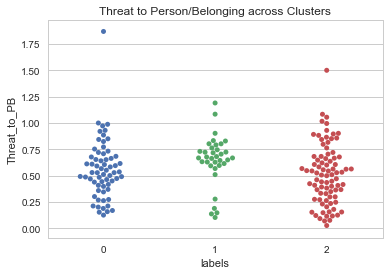

In [34]:
# 4. Variation in the Threat to person or Belonging across Clusters
sns.swarmplot(x="labels", y="Threat_to_PB", data=zip_df)
plt.title("Threat to Person/Belonging across Clusters")
plt.show()

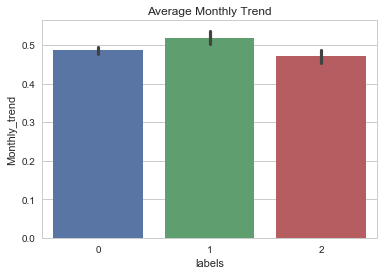

In [35]:
# 5. Variation in the Monthly trends for Zipcodes across Clusters
sns.barplot(x="labels", y="Monthly_trend", data=zip_df)
plt.title("Average Monthly Trend")
plt.show()

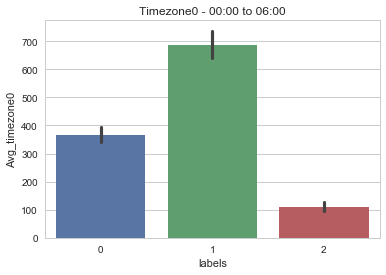

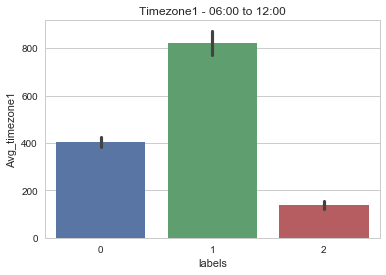

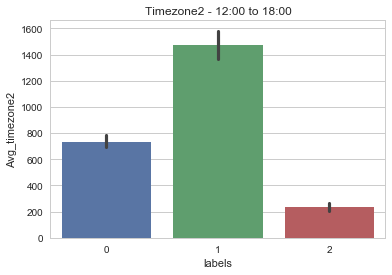

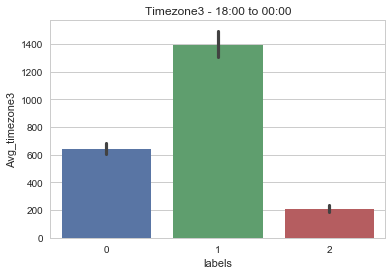

In [43]:
# 6. Distribution across Timezones
sns.barplot(x="labels", y="Avg_timezone0", data=zip_df)
plt.title("Timezone0 - 00:00 to 06:00")
plt.show()

sns.barplot(x="labels", y="Avg_timezone1", data=zip_df)
plt.title("Timezone1 - 06:00 to 12:00")
plt.show()

sns.barplot(x="labels", y="Avg_timezone2", data=zip_df)
plt.title("Timezone2 - 12:00 to 18:00")
plt.show()

sns.barplot(x="labels", y="Avg_timezone3", data=zip_df)
plt.title("Timezone3 - 18:00 to 00:00")
plt.show()

In [11]:
# Part B: Feature Engineering to extract crime statistics across Precincts

columns = ["Precinct", "Borough", "Avg_timezone0","Avg_timezone1","Avg_timezone2","Avg_timezone3",
           "Avg_month","Monthly_trend","Avg_felony","Felony_trend","Avg_misdem","Misdem_trend",
           "Avg_vio","Vio_trend","Threat_to_PB","Success_rate"]

pre_df = pd.DataFrame(index=np.arange(len(precincts)),columns=columns)
pre_df["Precinct"] = precincts

boroughs = []
timezone0 = []
timezone1 = []
timezone2 = []
timezone3 = []
month = []
felony = []
misdem = []
vio = []

# 1. Average number of crimes across each timezone, monthly averages, law category average for every Zipcode
for i in range(len(pre_df)):
    z = pre_df.iloc[i]["Precinct"]
    boroughs.append(df[df["ADDR_PCT_CD"]==z]["BORO_NM"].unique()[0].title())
    
    timezone0.append(len(df[(df["ADDR_PCT_CD"]==z) & (df["timezone"]==0)]))
    timezone1.append(len(df[(df["ADDR_PCT_CD"]==z) & (df["timezone"]==1)]))
    timezone2.append(len(df[(df["ADDR_PCT_CD"]==z) & (df["timezone"]==2)]))
    timezone3.append(len(df[(df["ADDR_PCT_CD"]==z) & (df["timezone"]==3)]))
    month.append(float(len(df[df["ADDR_PCT_CD"]==z]))/12)
    
    felony.append(float(len(df[(df["ADDR_PCT_CD"]==z) & (df["LAW_CAT_CD"]=="FELONY")]))/12)
    misdem.append(float(len(df[(df["ADDR_PCT_CD"]==z) & (df["LAW_CAT_CD"]=="MISDEMEANOR")]))/12)
    vio.append(float(len(df[(df["ADDR_PCT_CD"]==z) & (df["LAW_CAT_CD"]=="VIOLATION")]))/12)
    
pre_df["Borough"] = boroughs
pre_df["Avg_timezone0"] = timezone0
pre_df["Avg_timezone1"] = timezone1
pre_df["Avg_timezone2"] = timezone2
pre_df["Avg_timezone3"] = timezone3
pre_df["Avg_month"] = month
pre_df["Avg_felony"] = felony
pre_df["Avg_misdem"] = misdem
pre_df["Avg_vio"] = vio

In [12]:
# 2. Using Correlation to find linear trends in the crime statistics

mon_trend = []
fel_trend = []
mis_trend = []
vio_trend = []

for i in range(len(pre_df)):
    z = pre_df.iloc[i]["Precinct"]
    mon = np.zeros((12,))
    fel = np.zeros((12,))
    mis = np.zeros((12,))
    viol = np.zeros((12,))
    
    for j in range(12):
        mon[j] = len(df[(df["ADDR_PCT_CD"]==z) & (df["month"]==j)])
        fel[j] = len(df[(df["ADDR_PCT_CD"]==z) & (df["LAW_CAT_CD"]=="FELONY") & (df["month"]==j)])
        mis[j] = len(df[(df["ADDR_PCT_CD"]==z) & (df["LAW_CAT_CD"]=="MISDEMEANOR") & (df["month"]==j)])
        viol[j] = len(df[(df["ADDR_PCT_CD"]==z) & (df["LAW_CAT_CD"]=="VIOLATION") & (df["month"]==j)])
    
    # Find correlation in them
    mon_trend.append(np.corrcoef(np.arange(12),mon)[0,1])
    fel_trend.append(np.corrcoef(np.arange(12),fel)[0,1])
    mis_trend.append(np.corrcoef(np.arange(12),mis)[0,1])
    vio_trend.append(np.corrcoef(np.arange(12),viol)[0,1])

pre_df["Monthly_trend"] = mon_trend
pre_df["Felony_trend"] = fel_trend
pre_df["Misdem_trend"] = mis_trend
pre_df["Vio_trend"] = vio_trend

In [13]:
# 3. Calculate threat to either Person or Belonging based on key codes and offense descriptions - Threat_to_PB

rel_persons = set(["ASSUALT","HOMICIDE","FELONY","ARSON","SEX","INTOXICATED","DANGEROUS","DRUGS","WEAPONS",
               "KIDNAPPING","CRIMINAL","PENAL"])
rel_things = set(["ROBBERY","BURGLARY","LARCENY","THEFT","FRAUD","FORGERY","STOLEN","FRAUDULENT"])

harms_people = [102,103]
harms_things = [112]
for k,v in offense_code.items():
    temp = v.strip().split()
    for i in temp:
        if i in rel_persons:
            harms_people.append(k)
            break
        elif i in rel_things:
            harms_things.append(k)
            break

ratio = []
for i in range(len(pre_df)):
    z = pre_df.iloc[i]["Precinct"]
    val_p = 0
    val_t = 0
    for j in harms_people:
        val_p += len(df[(df["ADDR_PCT_CD"]==z) & (df["KY_CD"]==j)])
    for j in harms_things:
        val_t += len(df[(df["ADDR_PCT_CD"]==z) & (df["KY_CD"]==j)])
    if val_t==0:
        val_t = 1
    ratio.append(float(val_p)/val_t)
pre_df["Threat_to_PB"] = ratio

In [14]:
# 4. Calculating Success rate for every Precinct

success = []
for i in range(len(pre_df)):
    z = pre_df.iloc[i]["Precinct"]
    total = float(len(df[df["ADDR_PCT_CD"]==z]))
    attempted = len(df[(df["ADDR_PCT_CD"]==z) & (df["CRM_ATPT_CPTD_CD"]=="ATTEMPTED")])
    success.append(attempted/total)
pre_df["Success_rate"] = success

In [16]:
# KMeans Algorithm

pre_df = pre_df[~pre_df.isnull().any(axis=1)]
from sklearn.cluster import KMeans
def clustering(train, n):
    kmeans = KMeans(n_clusters=n, random_state=0,).fit(train)
    return kmeans.cluster_centers_, kmeans.labels_

usecols = ["Avg_timezone0","Avg_timezone1","Avg_timezone2","Avg_timezone3","Avg_month","Monthly_trend",
        "Avg_felony","Felony_trend","Avg_misdem","Misdem_trend","Avg_vio","Vio_trend","Threat_to_PB","Success_rate"]

num_clusters = 3
centers_p, labels_p = clustering(pre_df[usecols],num_clusters) 

pre_df['labels'] = labels_p
print pre_df['labels'].value_counts()

2    35
0    33
1     8
Name: labels, dtype: int64


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


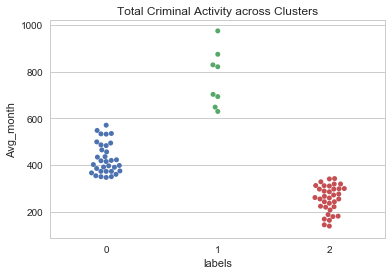

In [36]:
# Tests to see if the clusters had segregated well enough and to identify which cluster marks High criminal activity

# 1. Average monthly crime stats
sns.set(style="whitegrid", color_codes=True)
sns.swarmplot(x="labels", y="Avg_month", data=pre_df)
plt.title("Total Criminal Activity across Clusters")
plt.show()

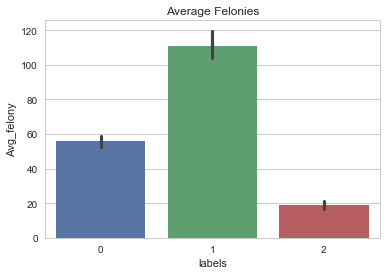

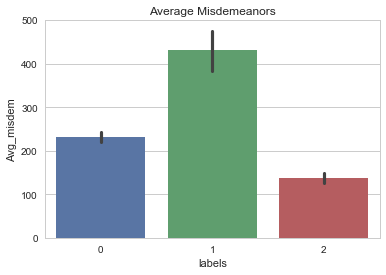

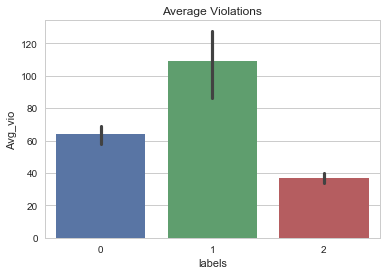

In [37]:
# 2. Comparing Crime stats for every category of crime - Felony, Misdemeanor, Violation
sns.barplot(x="labels", y="Avg_felony", data=zip_df)
plt.title("Average Felonies")
plt.show()

sns.barplot(x="labels", y="Avg_misdem", data=pre_df)
plt.title("Average Misdemeanors")
plt.show()

sns.barplot(x="labels", y="Avg_vio", data=pre_df)
plt.title("Average Violations")
plt.show()

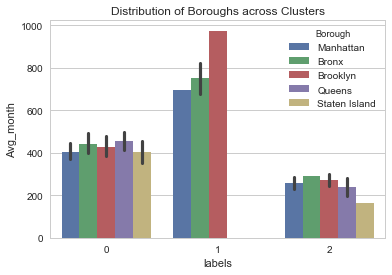

In [38]:
# 3. Distribution of Boroughs across Clusters
sns.barplot(x="labels", y="Avg_month", hue="Borough",data=pre_df)
plt.title("Distribution of Boroughs across Clusters")
plt.show()

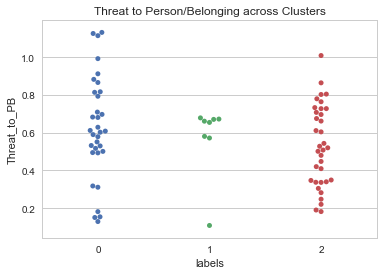

In [39]:
# 4. Variation in the Threat to person or Belonging across Clusters
sns.swarmplot(x="labels", y="Threat_to_PB", data=pre_df)
plt.title("Threat to Person/Belonging across Clusters")
plt.show()

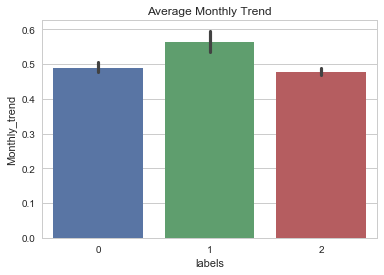

In [40]:
# 5. Variation in the Monthly trends for Precincts across Clusters
sns.barplot(x="labels", y="Monthly_trend", data=pre_df)
plt.title("Average Monthly Trend")
plt.show()

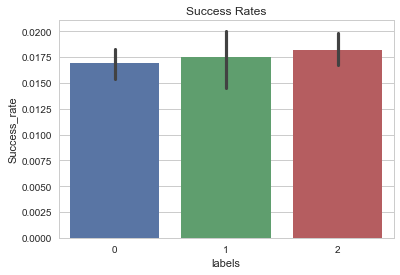

In [42]:
# 6. Success rate across Clusters
sns.barplot(x="labels", y="Success_rate", data=pre_df)
plt.title("Success Rates")
plt.show()

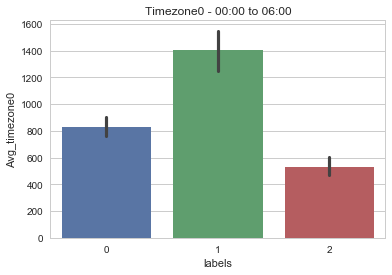

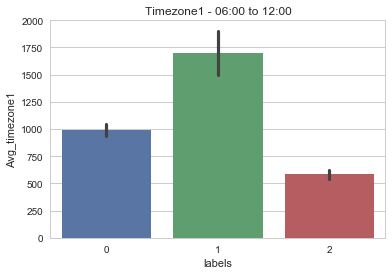

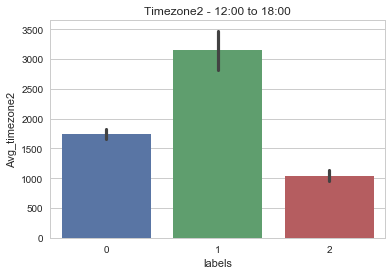

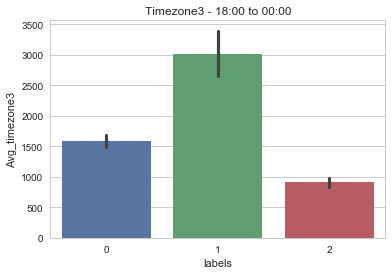

In [44]:
# 6. Distribution across Timezones
sns.barplot(x="labels", y="Avg_timezone0", data=pre_df)
plt.title("Timezone0 - 00:00 to 06:00")
plt.show()

sns.barplot(x="labels", y="Avg_timezone1", data=pre_df)
plt.title("Timezone1 - 06:00 to 12:00")
plt.show()

sns.barplot(x="labels", y="Avg_timezone2", data=pre_df)
plt.title("Timezone2 - 12:00 to 18:00")
plt.show()

sns.barplot(x="labels", y="Avg_timezone3", data=pre_df)
plt.title("Timezone3 - 18:00 to 00:00")
plt.show()